# Assessment 1: Predict diabetes using Perceptron

## Overview

The first assignment is to implement, describe, and test
a specific algorithm called Perceptron (which can be
interpreted as a dense layer neural network) for predicting
diabetes (using the diabetes dataset provided). 

## Import Packages


In [200]:
# Common imports
import numpy as np
import pandas as pd

# visualizaiton
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# machine learning & Deep learning imports
import sklearn
import torch


## Data Loading

In [211]:
def load_dataset(filename):
    # Read the data using whitespace as delimiter, assuming no headers
    data = pd.read_csv(filename, sep='\s+', header=None)
    print(data.info())
    # Extract labels and initialize the matrix for features
    labels = data.iloc[:, 0].apply(lambda x: 1 if int(x) == 1 else -1).values
    num_samples = data.shape[0]

    # Prepare to find the maximum index for feature array initialization
    max_index = 0
    for index, row in data.iterrows():
        for item in row:
            if isinstance(item, str) and ':' in item:
                feature_idx = int(item.split(':')[0])
                if feature_idx > max_index:
                    max_index = feature_idx
                    
    # Initialize the features array with NaN values
    features = np.full((num_samples, max_index), np.nan, dtype=np.float32)

    # Populate the features array
    for i, row in enumerate(data.itertuples(index=False)):
        for item in row:  
            if isinstance(item, str) and ':' in item:
                idx, val = item.split(':')
                features[i, int(idx) - 1] = float(val)  # Correct index and convert value

    # Convert labels and features into PyTorch tensors
    return torch.tensor(features), torch.tensor(labels, dtype=torch.float32)

# Load the pre-processed data diabetes_scale.txt
features, labels = load_dataset('diabetes_scale.txt')
print(features.shape, labels.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   0       768 non-null    int64 
 1   1       768 non-null    object
 2   2       768 non-null    object
 3   3       768 non-null    object
 4   4       768 non-null    object
 5   5       768 non-null    object
 6   6       768 non-null    object
 7   7       768 non-null    object
 8   8       759 non-null    object
dtypes: int64(1), object(8)
memory usage: 54.1+ KB
None
torch.Size([768, 8]) torch.Size([768])


## Check NaN values and the distribution of each feature

In [212]:
features_np = features.numpy()
labels_np = labels.numpy()

# Check for rows with missing values (np.nan)
rows_with_nan = np.any(np.isnan(features_np), axis=1)  # Returns a boolean array: True if the row has any NaN values

# Get the indices of rows with NaN values
nan_indices = np.where(rows_with_nan)[0]
print(f"Rows with NaN values: {nan_indices}")

Rows with NaN values: [ 14  24 236 259 285 401 458 517 658]


In [216]:
features_np[285]

array([-0.176471,  0.366834,  0.213115, -0.474747, -0.680851, -0.225037,
       -0.514091,       nan], dtype=float32)

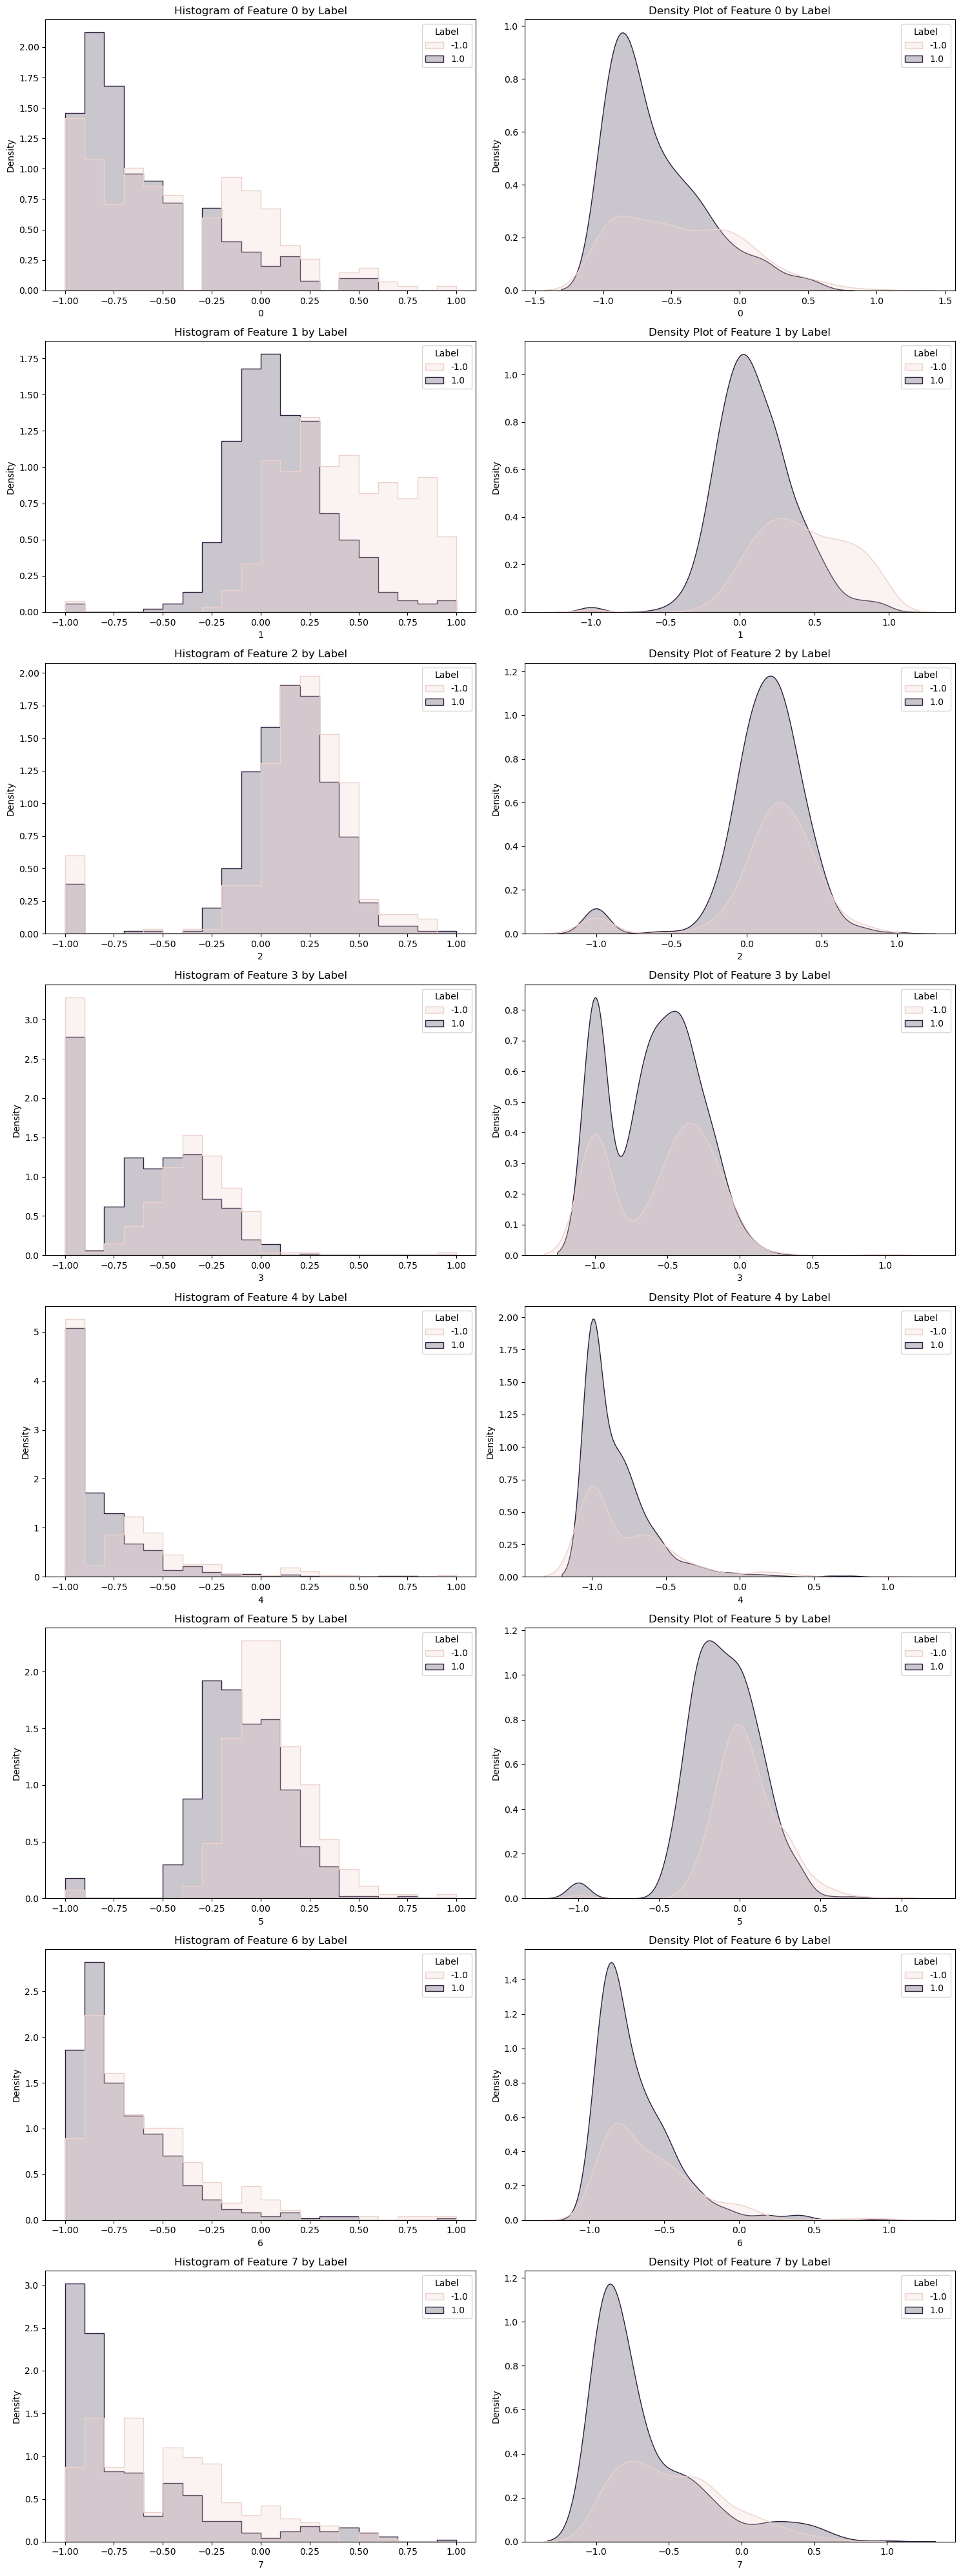

In [217]:
# Create a DataFrame for easier manipulation
df = pd.DataFrame(features_np)
df['Label'] = labels_np  # Add labels as a column in the DataFrame

# Set the number of features you want to plot (for simplicity, plotting 3 features here)
num_features = 8

plt.figure(figsize=(15, 5 * num_features))
for i in range(num_features):
    plt.subplot(num_features, 2, 2 * i + 1)
    sns.histplot(data=df, x=i, hue='Label', element='step', stat='density', common_norm=False, bins=20)
    plt.title(f'Histogram of Feature {i} by Label')

    plt.subplot(num_features, 2, 2 * i + 2)
    sns.kdeplot(data=df, x=i, hue='Label', fill=True)
    plt.title(f'Density Plot of Feature {i} by Label')

plt.tight_layout()
plt.show()

## Perceptron Model

In [218]:
import torch.nn as nn
import torch.optim as optim

class PyTorchPerceptron(nn.Module):
    def __init__(self, input_dim):
        super(PyTorchPerceptron, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_dim, 1),               
        )
    
    def forward(self, x):
        return self.fc(x)

In [219]:
def perceptron_loss(outputs, labels):
    # Compute the perceptron loss
    loss = torch.clamp(-labels * outputs, min=0)
    return torch.mean(loss)

In [220]:
# from sklearn.base import BaseEstimator, ClassifierMixin
from torch.utils.data import DataLoader, TensorDataset

class PyTorchPerceptronClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, input_dim, epochs=20, batch_size=16, learning_rate=0.001):
        self.input_dim = input_dim
        self.epochs = epochs
        self.batch_size = batch_size
        self.learning_rate = learning_rate
        self.model = PyTorchPerceptron(input_dim)
        # self.criterion = nn.BCELoss()
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=learning_rate)
        self.training_losses = []
        self.validation_losses = []
        
    def fit(self, X_train, y_train, X_val=None, y_val=None):
        # Convert training data to tensors
        X_tensor = torch.tensor(X_train, dtype=torch.float32)
        y_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
        train_dataset = TensorDataset(X_tensor, y_tensor)
        train_loader = DataLoader(train_dataset, batch_size=self.batch_size, shuffle=True)
        # for data, target in train_loader:
        #     self.optimizer.zero_grad()
        #     output = self.model(data)
        #     print("Output Range: Min:", output.min().item(), "Max:", output.max().item())  # Debugging line
        #     loss = self.criterion(output, target)
        #     loss.backward()
        #     self.optimizer.step()
        
        # Optionally prepare validation data
        val_loader = None
        if X_val is not None and y_val is not None:
            X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
            y_val_tensor = torch.tensor(y_val, dtype=torch.float32).unsqueeze(1)
            val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
            val_loader = DataLoader(val_dataset, batch_size=self.batch_size, shuffle=False)
        
        # Training loop
        self.model.train()
        for epoch in range(self.epochs):
            total_train_loss = 0
            counter = 10
            for inputs, targets in train_loader:
                self.optimizer.zero_grad()
                outputs = self.model(inputs)
                loss = perceptron_loss(outputs, targets)
                loss.backward()
                self.optimizer.step()
                total_train_loss += loss.item()
            avg_train_loss = total_train_loss / len(train_loader)
            self.training_losses.append(avg_train_loss)

            # Validation loop
            if val_loader:
                self.model.eval()
                total_val_loss = 0
                with torch.no_grad():
                    for inputs, targets in val_loader:
                        outputs = self.model(inputs)
                        loss = perceptron_loss(outputs, targets)
                        total_val_loss += loss.item()
                avg_val_loss = total_val_loss / len(val_loader)
                self.validation_losses.append(avg_val_loss)
            print(f"Epoch {epoch+1}/{self.epochs}: Train Loss: {total_train_loss / len(train_loader):.4f}, Val Loss: {total_val_loss / len(val_loader):.4f}")
    
    def predict(self, X):
        self.model.eval()
        X_tensor = torch.tensor(X, dtype=torch.float32)
        with torch.no_grad():
            outputs = self.model(X_tensor)
        return (outputs.numpy() > 0).astype(int)*2 - 1
    
    def score(self, X, y):
        predictions = self.predict(X)
        return np.mean(predictions == y)

## Pipeline of imputation and training

In [247]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
import numpy as np

# Load and split your data
# X and y should be loaded as numpy arrays from your dataset
X_train, X_temp, y_train, y_temp = train_test_split(features_np, labels_np, test_size=0.4, random_state=42, stratify=labels_np)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

# Assuming features_np and labels_np are your dataset's features and labels loaded as numpy arrays:
imputer = SimpleImputer(strategy='median')  

# Fit the imputer on the training data and transform it
X_train_imputed = imputer.fit_transform(X_train)
X_val_imputed = imputer.transform(X_val)  # Use the same imputer to transform the validation data

print("NaNs in X_train_imputed:", np.isnan(X_train_imputed).sum())
print("NaNs in X_val_imputed:", np.isnan(X_val_imputed).sum())

classifier = PyTorchPerceptronClassifier(input_dim=X_train.shape[1],epochs=20, batch_size=8, learning_rate=0.001)
classifier.fit(X_train_imputed, y_train, X_val=X_val_imputed, y_val=y_val)

NaNs in X_train_imputed: 0
NaNs in X_val_imputed: 0
Epoch 1/20: Train Loss: 0.1303, Val Loss: 0.1053
Epoch 2/20: Train Loss: 0.0921, Val Loss: 0.0755
Epoch 3/20: Train Loss: 0.0734, Val Loss: 0.0651
Epoch 4/20: Train Loss: 0.0650, Val Loss: 0.0578
Epoch 5/20: Train Loss: 0.0567, Val Loss: 0.0520
Epoch 6/20: Train Loss: 0.0503, Val Loss: 0.0471
Epoch 7/20: Train Loss: 0.0436, Val Loss: 0.0410
Epoch 8/20: Train Loss: 0.0379, Val Loss: 0.0366
Epoch 9/20: Train Loss: 0.0333, Val Loss: 0.0323
Epoch 10/20: Train Loss: 0.0291, Val Loss: 0.0289
Epoch 11/20: Train Loss: 0.0255, Val Loss: 0.0244
Epoch 12/20: Train Loss: 0.0225, Val Loss: 0.0215
Epoch 13/20: Train Loss: 0.0204, Val Loss: 0.0190
Epoch 14/20: Train Loss: 0.0180, Val Loss: 0.0170
Epoch 15/20: Train Loss: 0.0159, Val Loss: 0.0152
Epoch 16/20: Train Loss: 0.0142, Val Loss: 0.0135
Epoch 17/20: Train Loss: 0.0126, Val Loss: 0.0122
Epoch 18/20: Train Loss: 0.0119, Val Loss: 0.0109
Epoch 19/20: Train Loss: 0.0099, Val Loss: 0.0095
Epoch 2

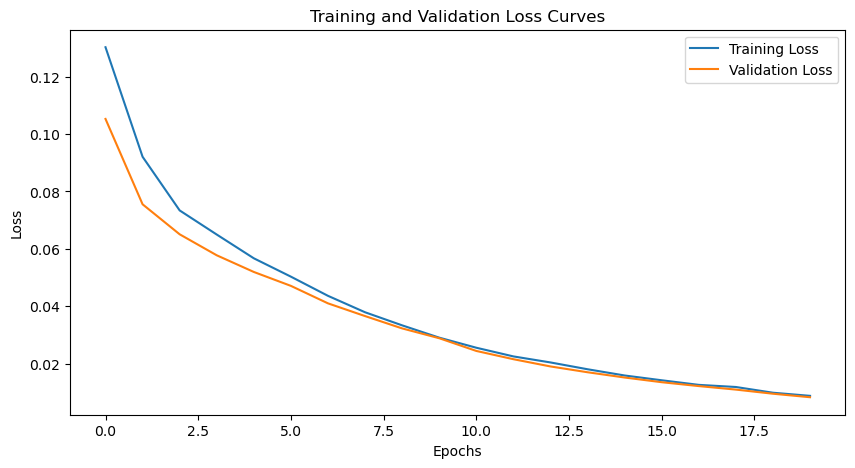

In [248]:
# Plot training and validation losses, assuming these are stored in the classifier after fitting
plt.figure(figsize=(10, 5))
plt.plot(classifier.training_losses, label='Training Loss')
plt.plot(classifier.validation_losses, label='Validation Loss')  # Make sure validation losses are recorded
plt.title('Training and Validation Loss Curves')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [249]:
# Assuming your test data is X_test and y_test
# First, make sure that X_test has been processed similarly to X_train (e.g., imputation)

# If you used a pipeline for preprocessing:
X_test_preprocessed = imputer.transform(X_test)  # Only if you used an imputer or any other preprocessing steps

# Predict using the classifier
y_pred = classifier.predict(X_test_preprocessed)

In [250]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", conf_matrix)

# Classification Report
class_report = classification_report(y_test, y_pred)
print("Classification Report:\n", class_report)

Accuracy: 0.7208
Confusion Matrix:
 [[33 21]
 [22 78]]
Classification Report:
               precision    recall  f1-score   support

        -1.0       0.60      0.61      0.61        54
         1.0       0.79      0.78      0.78       100

    accuracy                           0.72       154
   macro avg       0.69      0.70      0.69       154
weighted avg       0.72      0.72      0.72       154



In [251]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

param_grid = {'C': [0.1, 1, 10, 100, 1000]}  # Example range of C values
svm = SVC(kernel='rbf')
grid_search = GridSearchCV(svm, param_grid, cv=5)  # Using 5-fold cross-validation
grid_search.fit(X_train_imputed, y_train)
print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score: {:.2f}".format(grid_search.best_score_))

In [ ]:
# Initialize the SVM classifier
svm_classifier = SVC(kernel='rbf', C=1, random_state=42)